In [1]:
import sys
from pathlib import Path
sys.path.append("../src/")
sys.path.append("../src/AtomicH")
sys.path.append("../src/AtomicH/LitReview")
import numpy as np
import pylab as plt
import json
import os
import elastic
import constants
import potentials
import dipolelosses
from dipolelosses import DipoleChannels
import spinexchange
from spinexchange import SpinExChannels
from dipolelosses import GetSummedGFactor, GetGFactor, DipoleChannels
from constants import HydrogenConstants, BohrInAng, kb, TritiumConstants
from potentials import Silvera_Triplet as pot


try:
    here = Path(__file__).resolve().parent
except NameError:
    here = Path.cwd()              

src_root = (here / ".." / "src").resolve()
if str(src_root) not in sys.path:    
    sys.path.insert(0, str(src_root))

In [3]:
LIT_REVIEW = src_root / "AtomicH" / "LitReview"

def _xy(dataset):
    """Convert a dataset’s point list → (x, y) NumPy arrays."""
    x = np.fromiter((pt["value"][0] for pt in dataset), dtype=float)
    y = np.fromiter((pt["value"][1] for pt in dataset), dtype=float)
    return x, y

def load_json(fname, idx=None):
    """
    Parameters
    ----------
    fname : str | Path
        File name inside AtomicH/LitReview.
    idx   : None | int | iterable[int]
        Which datasets in 'datasetColl' to load.
        None → all, int → that single, list/tuple → specific ones.
    Returns
    -------
    list[(x, y)]  Each item is a pair of NumPy arrays.
    """
    with open(LIT_REVIEW / fname, "r") as fp:
        coll = json.load(fp)["datasetColl"]

    if idx is None:
        indices = range(len(coll))
    elif isinstance(idx, int):
        indices = [idx]
    else:
        indices = idx

    return [_xy(coll[i]["data"]) for i in indices]

In [20]:
(k, XS),                       = load_json("Al_Maaitah.json",                0)
(ccaaB, ccaaG),                = load_json("Stoof_Ex_and_aa_ad.json",        0)
(ccbdB, ccbdG),                = load_json("Stoof_Ex_and_aa_ad.json",        1)
(ccacB, ccacG),                = load_json("Stoof_Ex_and_aa_ad.json",        2)
(ddaaB, ddaaG),                = load_json("Stoof_Ex_and_aa_ad.json",        3)
(ddadB, ddadG),                = load_json("Stoof_Ex_and_aa_ad.json",        4)
(ddacB, ddacG),                = load_json("Stoof_Dip_ac.json",              0)
(ddccB, ddccG), (ddcdB, ddcdG) = load_json("Stoof_Dip_cd_cc.json",      [0, 1])
(ZygHaaK, ZygHaaSig),           = load_json("Zyg_1.b.json",                  0)
(ZygHadK, ZygHadSig),           = load_json("Zyg_1.a.json",                  0)
(ZygTaaK, ZygTaaSig),           = load_json("Zyg_3.b.json",                  0)
(ZygTadK, ZygTadSig),           = load_json("Zyg_3.a.json",                  0)
(Stoofaax, Stoofaay_raw),      = load_json("Stoof_aa_ad.json",               0)
(Stoofadx, Stoofady_raw),      = load_json("Stoof_aa_ad.json",               1)

mp   = 1.672621925e-27
me   = 9.1093837139e-31
muH  = me + mp / 2
bohr = 5.29177210544e-9
C    = 1e-2 / (constants.BohrInAng*1e-8)**2 * np.sqrt(muH / (2 * constants.kb)) * 1e-15

Stoofaay = C * Stoofaay_raw / np.sqrt(Stoofaax)
Stoofady = C * Stoofady_raw / np.sqrt(Stoofadx)

In [6]:
k_A  = np.linspace(1e-4, 4*constants.hcInEVAngstrom, 200)      
k_eV = k_A / constants.hcInEVAngstrom           

In [7]:
r0       = 1e-9
intlimit = 100 * constants.BohrInAng/constants.hcInEVAngstrom
rhos = np.linspace(r0, intlimit, 100)

muH=constants.HydrogenConstants.mu
muT=constants.TritiumConstants.mu

even_ls = np.arange(0, 16, 2)   

sigma_T_by_l = {}               
sigma_T_total = np.zeros_like(k_A)   # activate if you want Σ_l

for l in even_ls:
    sigma_T_partial = np.array([
        elastic.GetCrossSection(rhos, k, l, muT,
                                potentials.Silvera_Triplet, 'Radau')
        for k in k_A
    ])
    sigma_T_by_l[l] = sigma_T_partial 
    sigma_T_total   += sigma_T_by_l[l]       

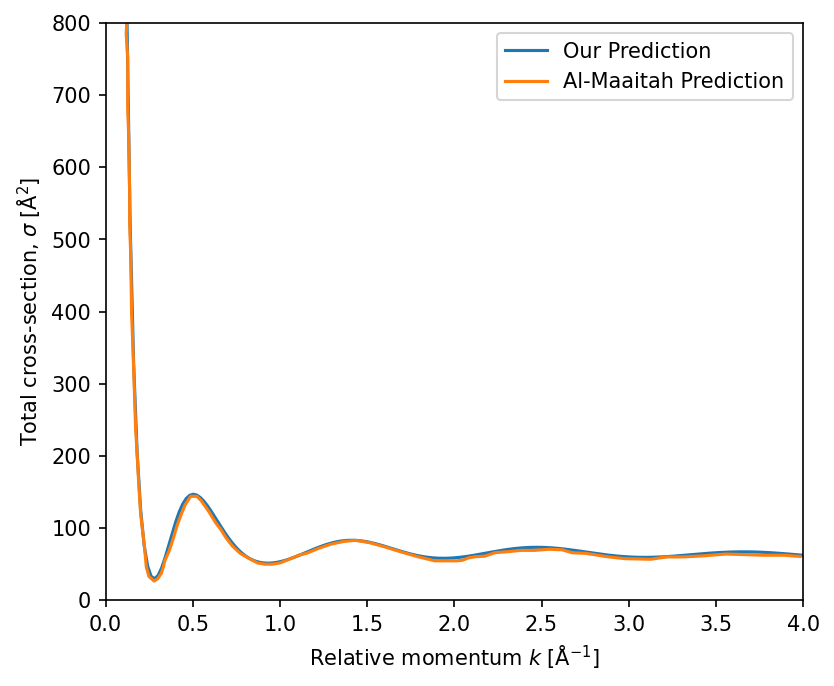

In [8]:
plt.figure(figsize=(6,5), dpi=150)
plt.plot(k_eV, np.array(sigma_T_total) * constants.hcInEVAngstrom**2, label="Our Prediction")  
plt.plot(k,XS, label="Al-Maaitah Prediction")
plt.xlabel(r'Relative momentum $k\;[\mathrm{\AA}^{-1}]$')
plt.ylabel(r'Total cross-section, $\sigma\;[\mathrm{\AA}^{2}]$')
plt.xlim(0, 4)
plt.ylim(0, 800)
plt.legend()

In [9]:
B_values = np.logspace(-3,1,50)

T        = 5e-4

GVsB_HDip=[]
GVsB_TDip=[]

for c in DipoleChannels:
    Gs=[]
    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.HydrogenConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_HDip.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.TritiumConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_TDip.append(np.array(Gs))

/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tole

In [10]:
potT     = potentials.Silvera_Triplet
potS     = potentials.Kolos_SingletCombo

T        = 1e-5

GVsB_HEx=[]
GVsB_TEx=[]

for c in SpinExChannels:
    Gs=[]
    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.HydrogenConstants, T, potT,potS,np.linspace(1e-9,0.75,2000)))
    GVsB_HEx.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.TritiumConstants, T, potT,potS,np.linspace(1e-9,0.75,2000)))
    GVsB_TEx.append(np.array(Gs))

In [11]:
# To make the plots with real B on x axis
#B_display=B_values

# To make the plots with Stoof scaled B on x axis
B_display=dipolelosses.B_Naught(B_values)

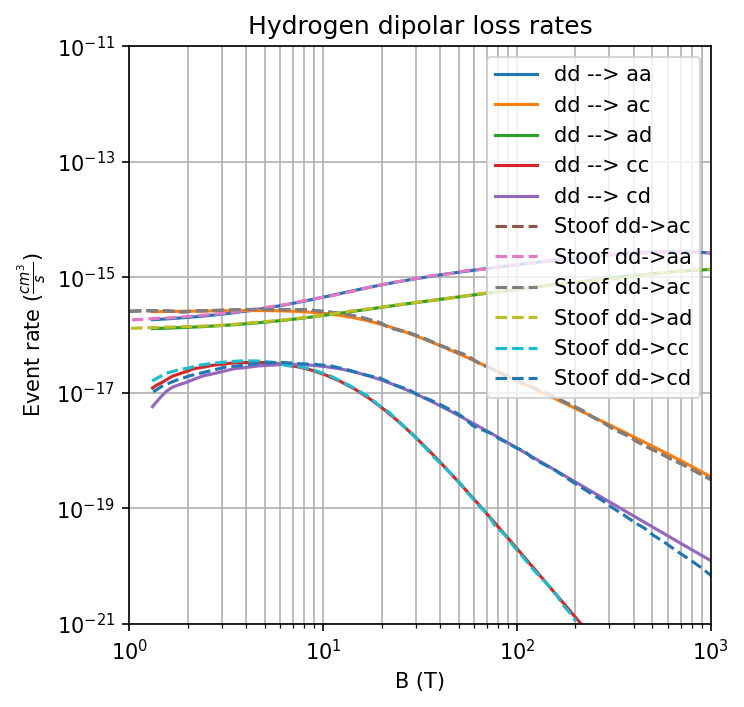

In [13]:
plt.figure(figsize=(5,5),dpi=150)

for ci in range(0,len(DipoleChannels)):
    Label='dd --> '+str(DipoleChannels[ci]['alphaprime'])+str(DipoleChannels[ci]['betaprime'])
    plt.plot(B_display,GVsB_HDip[ci],label=Label)
    plt.semilogy()

plt.plot(ddacB,ddacG,'--',label="Stoof dd->ac")
plt.plot(ddaaB,ddaaG,'--',label="Stoof dd->aa")
plt.plot(ddacB,ddacG,'--',label="Stoof dd->ac")
plt.plot(ddadB,ddadG,'--',label="Stoof dd->ad")
plt.plot(ddccB,ddccG,'--',label="Stoof dd->cc")
plt.plot(ddcdB,ddcdG,'--',label="Stoof dd->cd")

plt.xlabel("B (T)")
plt.xlim(1, 1e3)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21, 1e-11)
plt.title("Hydrogen dipolar loss rates")
plt.grid(which='both')
plt.legend()
plt.loglog()
plt.show()

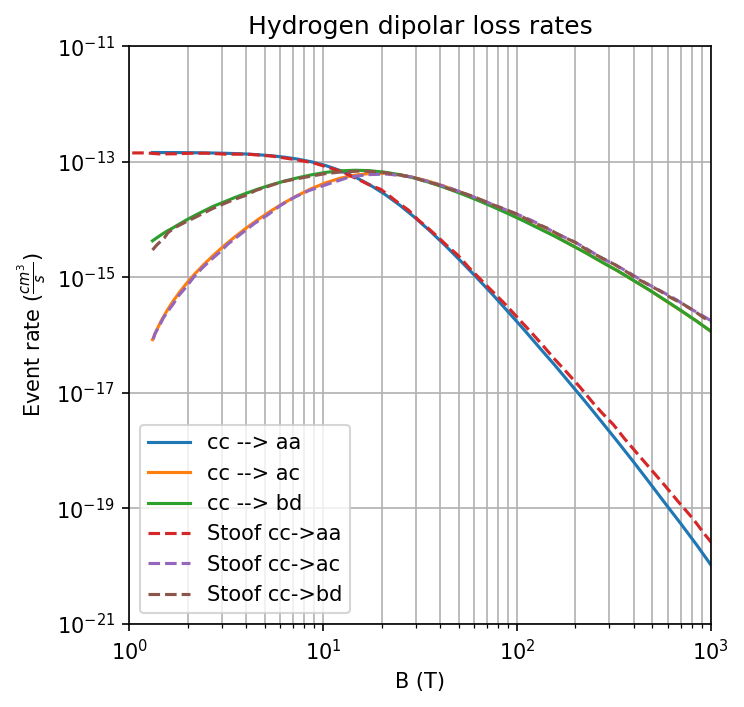

In [15]:
plt.figure(figsize=(5,5),dpi=150)

for ci in range(0,len(SpinExChannels)):
    Label='cc --> '+str(SpinExChannels[ci]['alphaprime'])+str(SpinExChannels[ci]['betaprime'])
    plt.plot(B_display, GVsB_HEx[ci],label=Label)
    plt.semilogy()

plt.plot(ccaaB,ccaaG,'--',label="Stoof cc->aa")
plt.plot(ccacB,ccacG,'--',label="Stoof cc->ac")
plt.plot(ccbdB,ccbdG,'--',label="Stoof cc->bd")

plt.xlabel("B (T)")
plt.xlim(1, 1e3)
plt.ylabel(r'Event rate ($\frac{cm^3}{s}$)')
plt.ylim(1e-21, 1e-11)
plt.title("Hydrogen dipolar loss rates")
plt.grid(which='both')
plt.legend()
plt.loglog()
plt.show()

In [16]:
T_values  = np.logspace(-3, 2, 50)           
B_value   = 1e-5                             
rhos_grid = np.linspace(1e-9, 0.75, 2000)     

P_WAVES     = [(0,2), (2,2), (2,4), (4,2), (4,4), (4,6)]
DEGENERACY  = [1] * len(P_WAVES)

amu      = 1.672621925e-27             
A_factor = 1e-6 / (BohrInAng*1e-10)**2 * np.sqrt( amu / (4*kb) )

COLORS = ["DarkRed", "DarkGreen"]

In [26]:
def compute_g_arrays(channel, iso):
    summedG = np.array([
        GetSummedGFactor(channel, B_value, iso, T, pot,
                         rhos=rhos_grid)
        for T in T_values
    ])

    partial_Gs = []
    for l_in, l_out in P_WAVES:
        g_vals = [
            GetGFactor(channel, B_value, iso, T, pot,
                       rhos=rhos_grid, lin=l_in, lout=l_out)
            for T in T_values
        ]
        partial_Gs.append(np.array(g_vals))

    return summedG, partial_Gs

def build_rate_table(channels,iso):
    table = []
    for ch in channels:
        summedG, partial_Gs = compute_g_arrays(ch,iso)
        table.append({
            "channel":  ch,
            "summed":   summedG,
            "partials": partial_Gs,
        })
    return table

channels_to_run = [DipoleChannels[0], DipoleChannels[2]]
Hrate_table = build_rate_table(channels_to_run,HydrogenConstants) 
Trate_table = build_rate_table(channels_to_run,TritiumConstants)

def channel_label(ch):
    a, b  = ch["alpha"],       ch["beta"]
    ap, bp = ch["alphaprime"], ch["betaprime"]
    return f"{a}{b}-{ap}{bp}"

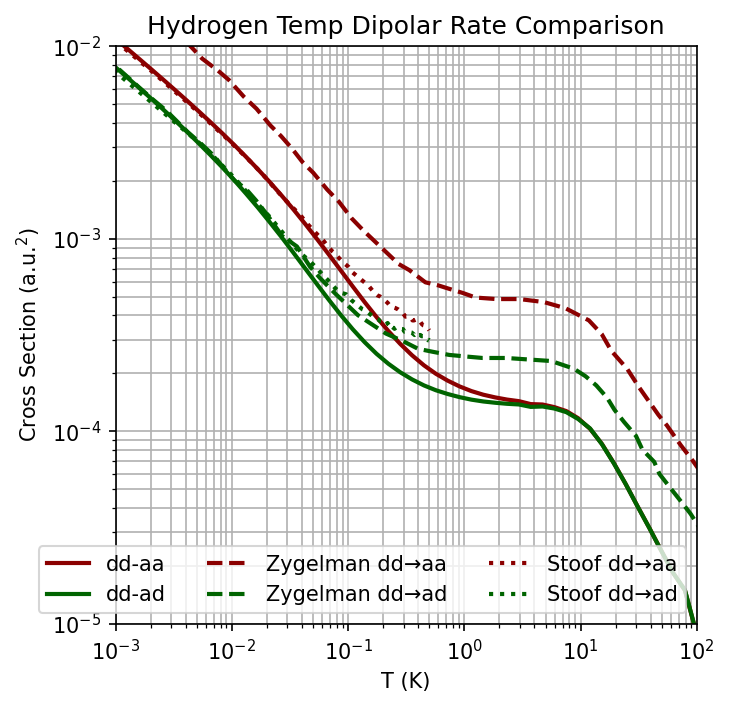

In [27]:
plt.figure(figsize=(5, 5), dpi=150)

for ch_idx, entry in enumerate(Hrate_table):
    summedG   = entry["summed"]
    partial_G = entry["partials"]
#    for pw_idx, (g, d) in enumerate(zip(partial_G, DEGENERACY)):
#        plt.plot(
#            T_values,
#            A_factor * g * d / np.sqrt(T_values),
#            color=PW_COLORS[pw_idx % len(PW_COLORS)],
#            linewidth=1)

    plt.plot(
        T_values,
        A_factor * summedG / np.sqrt(T_values),
        linewidth=2,
        color=COLORS[ch_idx % len(COLORS)],    
        label=channel_label(entry["channel"]))
    
plt.plot(ZygHaaK,  ZygHaaSig,  "--", color=COLORS[0], label="Zygelman dd→aa",linewidth=2)
plt.plot(ZygHadK,  ZygHadSig,  "--", color=COLORS[1], label="Zygelman dd→ad",linewidth=2)
plt.plot(Stoofaax, Stoofaay, ":",  color=COLORS[0], label="Stoof dd→aa",linewidth=2)
plt.plot(Stoofadx, Stoofady, ":",  color=COLORS[1], label="Stoof dd→ad",linewidth=2)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("T (K)")
plt.xlim(.001,100)
plt.ylabel(r"Cross Section (a.u.$^2$)")
plt.ylim(1e-5, .01)
plt.title("Hydrogen Temp Dipolar Rate Comparison")
plt.grid(which="both")
plt.legend(ncol=3)
plt.show()

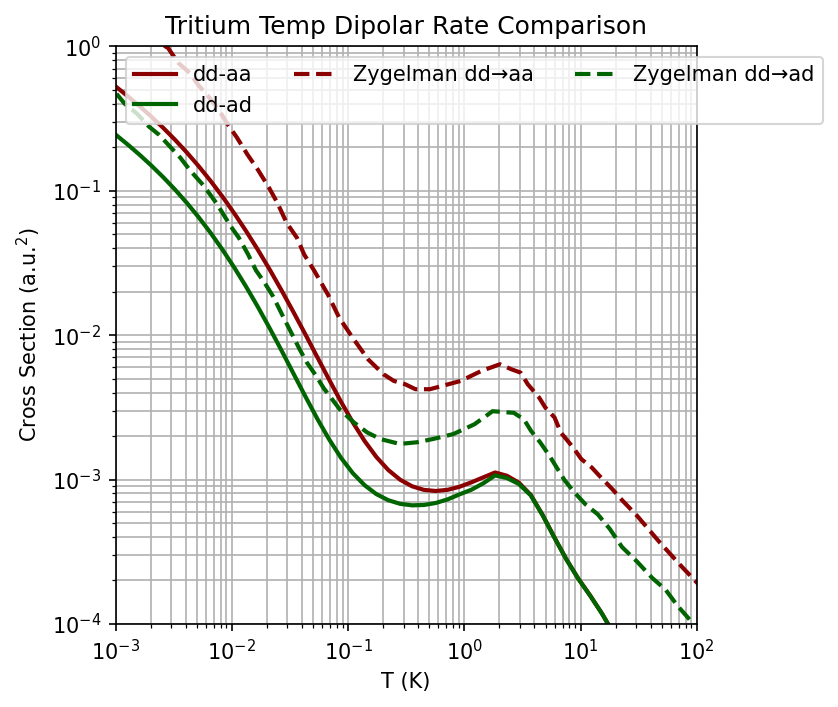

In [29]:
plt.figure(figsize=(5, 5), dpi=150)

for ch_idx, entry in enumerate(Trate_table):
    summedG   = entry["summed"]
    partial_G = entry["partials"]
#    for pw_idx, (g, d) in enumerate(zip(partial_G, DEGENERACY)):
#        plt.plot(
#            T_values,
#            A_factor * g * d / np.sqrt(T_values),
#            color=PW_COLORS[pw_idx % len(PW_COLORS)],
#            linewidth=1)

    plt.plot(
        T_values,
        A_factor * summedG / np.sqrt(T_values),
        linewidth=2,
        color=COLORS[ch_idx % len(COLORS)],    
        label=channel_label(entry["channel"]))
    
plt.plot(ZygTaaK,  ZygTaaSig,  "--", color=COLORS[0], label="Zygelman dd→aa",linewidth=2)
plt.plot(ZygTadK,  ZygTadSig,  "--", color=COLORS[1], label="Zygelman dd→ad",linewidth=2)

plt.xscale("log"); plt.yscale("log")
plt.xlabel("T (K)")
plt.xlim(.001,100)
plt.ylabel(r"Cross Section (a.u.$^2$)")
plt.ylim(1e-4,1)
plt.title("Tritium Temp Dipolar Rate Comparison")
plt.grid(which="both")
plt.legend(ncol=3)
plt.show()